# Introduction

In this competition, which seems to be hosted by some third party with data of the RDW, we are asked to predict the BPM of a motorcycle. The BPM is a taxation of passenger cars and motorcycles. This tax must be paid for each vehicle registered in the Netherlands. Even when you import it from abroad, if the vehicle is to be registered here (in the Netherlands), you have to pay the tax. Normally, this payment of the BPM is then taken care of by the importer.

Now, there are exact rules that apply to calculate the BPM. If these rules have changed over the past I don't yet know. 

In this notebook, we are going to predict these values.

(and check whether my motorcycles are also in the set ;) )

In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing

import warnings
warnings.filterwarnings('ignore')

In [182]:
_train = pd.read_csv('data/train.csv')
_test = pd.read_csv('data/test.csv')
_all = pd.concat({'train': _train, 'test': _test})

In [183]:
print((_all['Kenteken'] == "MJRG95").any())
print((_all['Kenteken'] == "MY61NH").any())

False
False


Oh well, too bad. They are probably too old now anyway. Although the law is of 1992.

In [184]:
_train.head()

,Kenteken,Merk,Datum eerste toelating,Datum tenaamstelling,Catalogusprijs,Massa ledig voertuig,Wielbasis,Aantal cilinders,Cilinderinhoud,WAM verzekerd,Bruto BPM
0,35MGKD,BMW,25/02/2016,25/11/2016,12254,180.0,153.0,2,798,1,1512
1,30MDST,SUZUKI,06/02/2014,06/02/2014,3699,122.0,139.0,1,125,1,330
2,18MFDK,HARLEY DAVIDSON,07/06/2014,19/03/2016,12395,247.0,153.0,2,1202,1,1557
3,54MHBT,KAWASAKI,23/09/2016,23/09/2016,6701,262.0,165.0,2,903,1,1090
4,44MGFB,SUZUKI,17/09/2015,25/03/2016,14499,200.0,146.0,4,999,0,1822


In [185]:
_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75630 entries, (test, 0) to (train, 37899)
Data columns (total 11 columns):
Aantal cilinders          75630 non-null int64
Bruto BPM                 37900 non-null float64
Catalogusprijs            75630 non-null int64
Cilinderinhoud            75630 non-null int64
Datum eerste toelating    75622 non-null object
Datum tenaamstelling      75630 non-null object
Kenteken                  75630 non-null object
Massa ledig voertuig      75596 non-null float64
Merk                      75630 non-null object
WAM verzekerd             37900 non-null float64
Wielbasis                 75625 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 7.0+ MB


First do something about the dates, which are encoded as strings. Let's make them numbers instead. I don't think the months are relevant, but let's encode that as the number of months since the earliest month in the set.

We are also mussing some 'Datum eerste toelating' feature values, since there are only 8, we will assume them to be the same as 'Datum tenaamstelling'.

In [186]:
_all['Datum eerste toelating'] = _all['Datum eerste toelating'].fillna(_all['Datum tenaamstelling'])

In [187]:
_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75630 entries, (test, 0) to (train, 37899)
Data columns (total 11 columns):
Aantal cilinders          75630 non-null int64
Bruto BPM                 37900 non-null float64
Catalogusprijs            75630 non-null int64
Cilinderinhoud            75630 non-null int64
Datum eerste toelating    75630 non-null object
Datum tenaamstelling      75630 non-null object
Kenteken                  75630 non-null object
Massa ledig voertuig      75596 non-null float64
Merk                      75630 non-null object
WAM verzekerd             37900 non-null float64
Wielbasis                 75625 non-null float64
dtypes: float64(4), int64(3), object(4)
memory usage: 7.0+ MB


In [188]:
_all['Jaar tenaamstelling'] = _all['Datum tenaamstelling'].str.split("/").str[-1].astype(int)
_all['Jaar eerste toelating'] = _all['Datum eerste toelating'].str.split("/").str[-1].astype(int)

In [189]:
_year_zero = int(_all.sort_values('Jaar eerste toelating')['Jaar eerste toelating'][0])
print(type(_year_zero), _year_zero)

<class 'int'> 1979


In [190]:
_all['Maanden tenaamstelling'] = (_all['Datum tenaamstelling'].str.split("/").str[-1].astype(int)-_year_zero)*12 + _all['Datum tenaamstelling'].str.split("/").str[1].astype(int)
_all['Maanden eerste toelating'] = (_all['Datum eerste toelating'].str.split("/").str[-1].astype(int)-_year_zero)*12 + _all['Datum eerste toelating'].str.split("/").str[1].astype(int)

In [191]:
_all = _all.drop(columns=['Datum eerste toelating', 'Datum tenaamstelling'])

In [192]:
_all.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 75630 entries, (test, 0) to (train, 37899)
Data columns (total 13 columns):
Aantal cilinders            75630 non-null int64
Bruto BPM                   37900 non-null float64
Catalogusprijs              75630 non-null int64
Cilinderinhoud              75630 non-null int64
Kenteken                    75630 non-null object
Massa ledig voertuig        75596 non-null float64
Merk                        75630 non-null object
WAM verzekerd               37900 non-null float64
Wielbasis                   75625 non-null float64
Jaar tenaamstelling         75630 non-null int64
Jaar eerste toelating       75630 non-null int64
Maanden tenaamstelling      75630 non-null int64
Maanden eerste toelating    75630 non-null int64
dtypes: float64(4), int64(7), object(2)
memory usage: 8.2+ MB


In [193]:
_all.loc[_all['Massa ledig voertuig'].isnull()]

Aantal cilinders  Bruto BPM  Catalogusprijs  Cilinderinhoud  \
test  347                   1        NaN            9299             449   
      3098                  1        NaN            3879             171   
      4955                  1        NaN            1200             124   
      7119                  1        NaN            3649             172   
      18649                 2        NaN           12195             798   
      24520                 1        NaN            1115             124   
      24980                 1        NaN            1499             100   
      25579                 1        NaN            9299             449   
      25660                 2        NaN            1103            1340   
      29045                 2        NaN            5749             252   
      32274                 4        NaN           23231             999   
      33894                 3        NaN           12750            1131   
      36487                 2        NaN           12990             998   
train 75                    2     1708.0           13476            1064   
      1130                  1      112.0            1499             125   
      1339                  4     2261.0           17677             999   
      3042                  2     2095.0           16473             798   
      3421                  4     3044.0           23343             999   
      5254                  6     4786.0           35949            1649   
      7099                  1      519.0            4999             124   
      15622                 6     4097.0           30965            1649   
      15722                 1      316.0            3599             125   
      16034                 6     4786.0           35949            1649   
      16630                 1      305.0            3470             153   
      16899                 1      363.0            3879             171   
      19015                 2     1763.0           13871            1312   
      20582                 2     1659.0           13318             647   
      25275                 2     1750.0           13980             647   
      25789                 1      363.0            3879             171   
      27895                 2     1675.0           13436             647   
      29775                 1      519.0            4999             124   
      33311                 1      305.0            3470             153   
      34410                 2     3108.0           23800            1690   
      35492                 1      112.0            1499             125   

            Kenteken  Massa ledig voertuig             Merk  WAM verzekerd  \
test  347     03MDJX                   NaN          GAS GAS            NaN   
      3098    MZND21                   NaN              SYM            NaN   
      4955    MXVJ77                   NaN          SKYTEAM            NaN   
      7119    MZHL13                   NaN              SYM            NaN   
      18649   88MGZL                   NaN              BMW            NaN   
      24520   17MBVV                   NaN          SKYTEAM            NaN   
      24980   74MBHT                   NaN          PEUGEOT            NaN   
      25579   41MDPS                   NaN          GAS GAS            NaN   
      25660   MT64HK                   NaN        EIGENBOUW            NaN   
      29045   MZTJ18                   NaN            KYMCO            NaN   
      32274   34MGVP                   NaN              BMW            NaN   
      33894   49MBNP                   NaN          BENELLI            NaN   
      36487   42MBJP                   NaN          APRILIA            NaN   
train 75      MZFG68                   NaN       MOTO-GUZZI            1.0   
      1130    MXVS63                   NaN              TGB            1.0   
      1339    64MGZN                   NaN              BMW            1.0   
      3042    41MGZT      

In [194]:
_all.loc[(_all['Cilinderinhoud'] == 449) & (_all['Wielbasis'] == 147.0)]['Massa ledig voertuig'].mean()

117.0

In [196]:
#_all.loc[_all['Massa ledig voertuig'].isnull(), 'Massa ledig voertuig'] = 

Some values for 'Massa ledig voertuig' are missing. But most of them can be imputed by taking motorcycles with the same 'Wielbasis' and the same 'Cilinderinhoud'.

In [219]:
#_all['Massa ledig voertuig'] = 
#_all.groupby(['Wielbasis', "Cilinderinhoud"],  as_index=False)['Massa ledig voertuig'].mean()
def get_MLV_estimation(ci, wb, mlv):
    if mlv is "NaN" or np.isnan(mlv):
        return _all.loc[(_all['Cilinderinhoud'] == ci) & (_all['Wielbasis'] == wb)]['Massa ledig voertuig'].mean()
    return mlv
def get_MLV_estimation2(ci, mlv):
    if mlv is "NaN" or np.isnan(mlv):
        return _all.loc[_all['Cilinderinhoud'] == ci]['Massa ledig voertuig'].mean()
    return mlv
def get_MLV_estimation_brand(brand, mlv):
    if mlv is "NaN" or np.isnan(mlv):
        return _all.loc[_all['Merk'] == brand]['Massa ledig voertuig'].mean()
    return mlv
#_all.groupby(['Wielbasis', "Cilinderinhoud"],  as_index=False)['Massa ledig voertuig'].mean()

In [212]:
get_MLV_estimation(449, 147.0, "NaN")

117.0

In [213]:
_all['Massa ledig voertuig'] = _all.apply(lambda x: get_MLV_estimation(x['Cilinderinhoud'], x['Wielbasis'], x['Massa ledig voertuig']), axis=1)

In [214]:
_all.loc[_all['Massa ledig voertuig'].isnull()]

Aantal cilinders  Bruto BPM  Catalogusprijs  Cilinderinhoud  \
test  7119                  1        NaN            3649             172   
      24980                 1        NaN            1499             100   
      25660                 2        NaN            1103            1340   
      29045                 2        NaN            5749             252   
      33894                 3        NaN           12750            1131   
train 19015                 2     1763.0           13871            1312   

            Kenteken  Massa ledig voertuig       Merk  WAM verzekerd  \
test  7119    MZHL13                   NaN        SYM            NaN   
      24980   74MBHT                   NaN    PEUGEOT            NaN   
      25660   MT64HK                   NaN  EIGENBOUW            NaN   
      29045   MZTJ18                   NaN      KYMCO            NaN   
      33894   49MBNP                   NaN    BENELLI            NaN   
train 19015   MZTV18                   NaN      HONDA            1.0   

             Wielbasis  Jaar tenaamstelling  Jaar eerste toelating  \
test  7119       143.0                 2011                   2011   
      24980      125.0                 2016                   2012   
      25660        NaN                 2012                   1995   
      29045      162.0                 2016                   2011   
      33894      142.0                 2012                   2012   
train 19015      167.0                 2013                   2011   

             Maanden tenaamstelling  Maanden eerste toelating  
test  7119                      389                       389  
      24980                     452                       399  
      25660                     400                       200  
      29045                     447                       390  
      33894                     401                       401  
train 19015                     420                       390

Okay, still 5 test instances missing the value, and 1 training instance. Now just focus on the 'Cilinderinhoud'. Especially custom builds 'EIGENBOUW' will not correspond to anything else otherwise.

In [215]:
_all['Massa ledig voertuig'] = _all.apply(lambda x: get_MLV_estimation2(x['Cilinderinhoud'], x['Massa ledig voertuig']), axis=1)

In [216]:
_all.loc[_all['Massa ledig voertuig'].isnull()]

Aantal cilinders  Bruto BPM  Catalogusprijs  Cilinderinhoud  \
test 7119                  1        NaN            3649             172   
     24980                 1        NaN            1499             100   
     29045                 2        NaN            5749             252   

           Kenteken  Massa ledig voertuig     Merk  WAM verzekerd  Wielbasis  \
test 7119    MZHL13                   NaN      SYM            NaN      143.0   
     24980   74MBHT                   NaN  PEUGEOT            NaN      125.0   
     29045   MZTJ18                   NaN    KYMCO            NaN      162.0   

            Jaar tenaamstelling  Jaar eerste toelating  \
test 7119                  2011                   2011   
     24980                 2016                   2012   
     29045                 2016                   2011   

            Maanden tenaamstelling  Maanden eerste toelating  
test 7119                      389                       389  
     24980                     452                       399  
     29045                     447                       390

Oh what the hell. Just give them the same as the median of the brand... It's just 3 cases anyway...

In [220]:
_all['Massa ledig voertuig'] = _all.apply(lambda x: get_MLV_estimation_brand(x['Merk'], x['Massa ledig voertuig']), axis=1)
_all.loc[_all['Massa ledig voertuig'].isnull()]

,,Aantal cilinders,Bruto BPM,Catalogusprijs,Cilinderinhoud,Kenteken,Massa ledig voertuig,Merk,WAM verzekerd,Wielbasis,Jaar tenaamstelling,Jaar eerste toelating,Maanden tenaamstelling,Maanden eerste toelating


Now let's do the same trick for 'Wielbasis'.

In [225]:
def get_WB_estimation(ci, wb):
    if wb is "NaN" or np.isnan(wb):
        return _all.loc[_all['Cilinderinhoud'] == ci]['Wielbasis'].mean()
    return wb

In [226]:
_all['Wielbasis'] = _all.apply(lambda x: get_WB_estimation(x['Cilinderinhoud'], x['Wielbasis']), axis=1)
_all.loc[_all['Wielbasis'].isnull()]

,,Aantal cilinders,Bruto BPM,Catalogusprijs,Cilinderinhoud,Kenteken,Massa ledig voertuig,Merk,WAM verzekerd,Wielbasis,Jaar tenaamstelling,Jaar eerste toelating,Maanden tenaamstelling,Maanden eerste toelating
train,22144,6,2211.0,2211,1500,MY50YD,338.0,HONDA,1.0,NaN,2015,2000,433,256


Okay, let's just look it up for this Honda. Ugh, Goldwings...

In [231]:
_all.loc[_all['Cilinderinhoud'] == 1500, 'Wielbasis'] = 169.0
_all.loc[_all['Cilinderinhoud'] == 1500]

,,Aantal cilinders,Bruto BPM,Catalogusprijs,Cilinderinhoud,Kenteken,Massa ledig voertuig,Merk,WAM verzekerd,Wielbasis,Jaar tenaamstelling,Jaar eerste toelating,Maanden tenaamstelling,Maanden eerste toelating
train,22144,6,2211.0,2211,1500,MY50YD,338.0,HONDA,1.0,169.0,2015,2000,433,256


In [221]:
_all.isnull().sum()

Aantal cilinders                0
Bruto BPM                   37730
Catalogusprijs                  0
Cilinderinhoud                  0
Kenteken                        0
Massa ledig voertuig            0
Merk                            0
WAM verzekerd               37730
Wielbasis                       5
Jaar tenaamstelling             0
Jaar eerste toelating           0
Maanden tenaamstelling          0
Maanden eerste toelating        0
dtype: int64

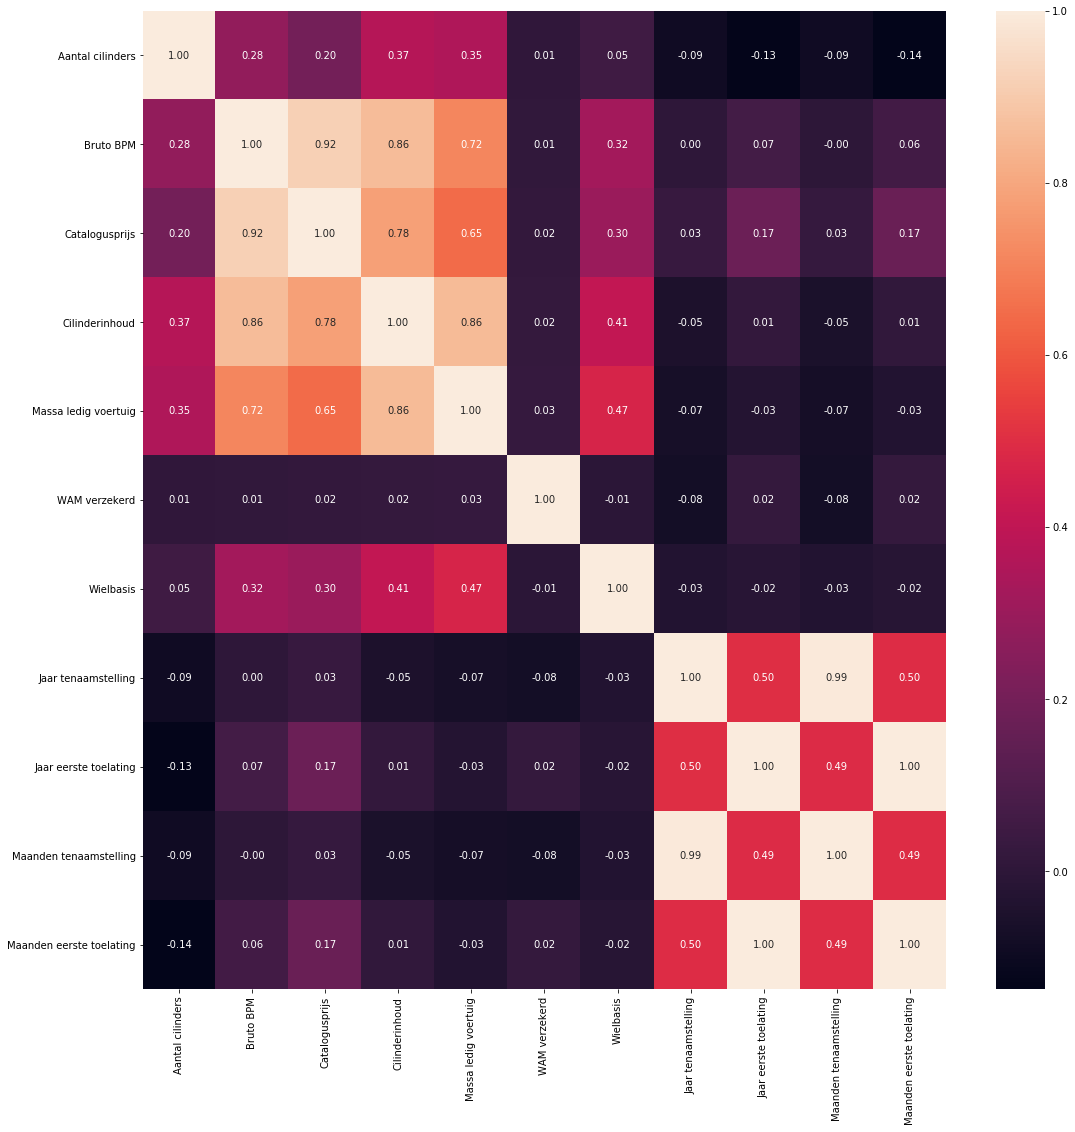

In [232]:
f,ax = plt.subplots(figsize=(18, 18))
sns.heatmap(_all.loc["train"].corr(), annot=True, fmt=".2f")
plt.show()

In [88]:
import xgboost as xgb

In [234]:
_n_folds = 10
#params = {'eta': 0.02, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'objective': 'binary:logistic', 'seed': 99, 'silent': 1, 'eval_metric':'auc', 'nthread':4}


parameters = {'nthread':[1], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.05], #so called `eta` value
              'max_depth': [6],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [0.8],
              'colsample_bytree': [0.7],
              'n_estimators': [1000], #number of trees, change it to 1000 for better results
              'missing':[-999],
              'seed': [1337]}




In [235]:
xgb_model = xgb.XGBClassifier()
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [236]:


from sklearn.cross_validation import *
clf = GridSearchCV(xgb_model, parameters, n_jobs=5, 
                   cv=StratifiedKFold(_all.loc["train"]["Bruto BPM"], n_folds=_n_folds, shuffle=True), 
                   scoring='accuracy',
                   verbose=2, refit=True)



In [237]:
features = ['Aantal cilinders', 
            'Catalogusprijs', 
            'Cilinderinhoud', 
            'Massa ledig voertuig', 
            'WAM verzekerd', 
            'Wielbasis', 
            'Jaar tenaamstelling', 
            'Jaar eerste toelating', 
            'Maanden tenaamstelling', 
            'Maanden eerste toelating']
bst = clf.fit(_all.loc["train"][features], _all.loc["train"]["Bruto BPM"])

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000, nthread=1, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000, nthread=1, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000, nthread=1, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000, nthread=1, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 
[CV] colsample_bytree=0.7, learning_rate=0.05, max_depth=6, min_child_weight=11, missing=-999, n_estimators=1000, nthread=1, objective=binary:logistic, seed=1337, silent=1, subsample=0.8 

KeyboardInterrupt: 